# HW 5-1 真實資料的迴歸

> Hsiao, Wei-pin @ NTNU Math

說明：

- 資料：使用美國郡級資料，預測每個地區的個人所得與其他經濟數據的關係(採用了失業率、人口密度、大學文憑占勞工人口比例三個變數)
- 模型：使用線性迴歸，假設有截距項，即：
  $$
  Y_{個人所得} = \beta_0 + \beta_1 X_{失業率} + \beta_2 X_{人口密度} + \beta_3 X_{大學文憑比} + \varepsilon
  $$
- 結論：除大學文憑比外其餘變數皆為顯著

---

## 基本設定

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import pathlib
import urllib.request
import zipfile

mpl.rc('font', family='Arial Unicode MS')

## 資料匯入

資料來源：[美國農業部ERS(Economic Research Service)](https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/) & [census.gov](https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.2018.html)

讀取 ERS 的最新(目前為2017之資料)的郡級資料(文憑人口比例來自 Education 表單、失業率與所得資料來自 Unemployment 表單、人口數來自 PopulationEstimates 表單)，由於需要計算人扣密度尚缺地理資訊(土地面積)，從 census.gov 的 gazetteer-files 補充相關資料。

In [2]:
local = pathlib.PurePath('Data/HW5-1_downlad_data.zip')
url = "https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2018_Gazetteer/2018_Gaz_counties_national.zip"
urllib.request.urlretrieve(url, local)
s4_zip = zipfile.ZipFile(local, 'r')

s1 = pd.read_csv("https://www.ers.usda.gov/webdocs/DataFiles/48747/Unemployment.csv?v=9329.4")
s2 = pd.read_csv("https://www.ers.usda.gov/webdocs/DataFiles/48747/Education.csv?v=6603", encoding='iso-8859-1')
s3 = pd.read_csv("https://www.ers.usda.gov/webdocs/DataFiles/48747/PopulationEstimates.csv?v=4934.5", encoding='iso-8859-1')
s4 = pd.read_csv(s4_zip.open('2018_Gaz_counties_national.txt'), sep='\t')
s4.columns = s4.columns.str.replace(' ', '')

整合不同表單的資料並刪去不要的數據，順便為了方便後續再利用，將整合後資料表儲存於 [Data/HW5-1_USDAERS_COUNTY.csv](Data/HW5-1_USDAERS_COUNTY.csv) 。

In [3]:
s1 = s1[['FIPStxt', 'State', 'Area_name', 'Unemployment_rate_2017', 'Median_Household_Income_2017']]
s2 = s2[['FIPS Code', 'State', 'Area name',
         'Percent of adults with less than a high school diploma, 2013-17',
         'Percent of adults with a high school diploma only, 2013-17',
         "Percent of adults completing some college or associate's degree, 2013-17",
         "Percent of adults with a bachelor's degree or higher, 2013-17"]]
s3 = s3[['FIPS', 'State', 'Area_Name', 'POP_ESTIMATE_2017']]
s4 = s4[['USPS', 'GEOID', 'ANSICODE', 'NAME', 'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT', 'INTPTLONG']]

s12 = pd.merge(s1, s2, left_on='FIPStxt', right_on='FIPS Code')
s123 = pd.merge(s12, s3, left_on='FIPStxt', right_on='FIPS')
s1234 = pd.merge(s123, s4, left_on='FIPStxt', right_on='GEOID')
USDAERS_COUNTY = s1234[['FIPS', 'State', 'Area_name', 'Unemployment_rate_2017', 'Median_Household_Income_2017',
                        "Percent of adults with a bachelor's degree or higher, 2013-17", 'POP_ESTIMATE_2017',
                        'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT', 'INTPTLONG']]

USDAERS_COUNTY.to_csv(pathlib.PurePath('Data/HW5-1_USDAERS_COUNTY.csv'))
USDAERS_COUNTY = USDAERS_COUNTY.dropna(axis=0, how='any') 

稍微檢視一下資料狀況

In [4]:
USDAERS_COUNTY.head()

,FIPS,State,Area_name,Unemployment_rate_2017,Median_Household_Income_2017,"Percent of adults with a bachelor's degree or higher, 2013-17",POP_ESTIMATE_2017,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,1001.0,AL,"Autauga County, AL",3.9,"$58,343",25.0,"55,504",594.444,9.926,32.532237,-86.646440
1,1003.0,AL,"Baldwin County, AL",4.0,"$56,607",30.7,"212,628",1589.794,437.475,30.659218,-87.746067
2,1005.0,AL,"Barbour County, AL",5.9,"$32,490",12.0,"25,270",885.002,19.513,31.870253,-85.405104
3,1007.0,AL,"Bibb County, AL",4.4,"$45,795",13.2,"22,668",622.461,3.707,33.015893,-87.127148
4,1009.0,AL,"Blount County, AL",4.0,"$48,253",13.1,"58,013",644.831,5.797,33.977358,-86.566440


## 線性迴歸分析

### 資料前處理

由於模型僅需要個人所得(`Median_Household_Income_2017`)、失業率(`Unemployment_rate_2017`)、大學文憑比(`Percent of adults with a bachelor's degree or higher, 2013-17`)、人口密度(`Population_Density`)，其中人口密度上需要計算(由`POP_ESTIMATE_2017`/`ALAND_SQMI`計算)，而個人所得讀入時為文字型態，需將其他符號去除後再轉換。

In [5]:
import locale

locale.setlocale(locale.LC_NUMERIC, '')
USDAERS_COUNTY["POP_ESTIMATE_2017"] = USDAERS_COUNTY["POP_ESTIMATE_2017"].apply(locale.atof)

USDAERS_COUNTY["Median_Household_Income_2017"] = USDAERS_COUNTY["Median_Household_Income_2017"].str.replace("$", "")
USDAERS_COUNTY["Median_Household_Income_2017"] = USDAERS_COUNTY["Median_Household_Income_2017"].str.replace(",", "")
USDAERS_COUNTY["Median_Household_Income_2017"] = USDAERS_COUNTY["Median_Household_Income_2017"].astype(float)
USDAERS_COUNTY["Population_Density"] = USDAERS_COUNTY["POP_ESTIMATE_2017"]/USDAERS_COUNTY["ALAND_SQMI"]

XY = USDAERS_COUNTY[['Median_Household_Income_2017', 'Unemployment_rate_2017',
                     "Percent of adults with a bachelor's degree or higher, 2013-17",
                     "Population_Density"]]

先看散佈圖，觀察各變數的狀況：

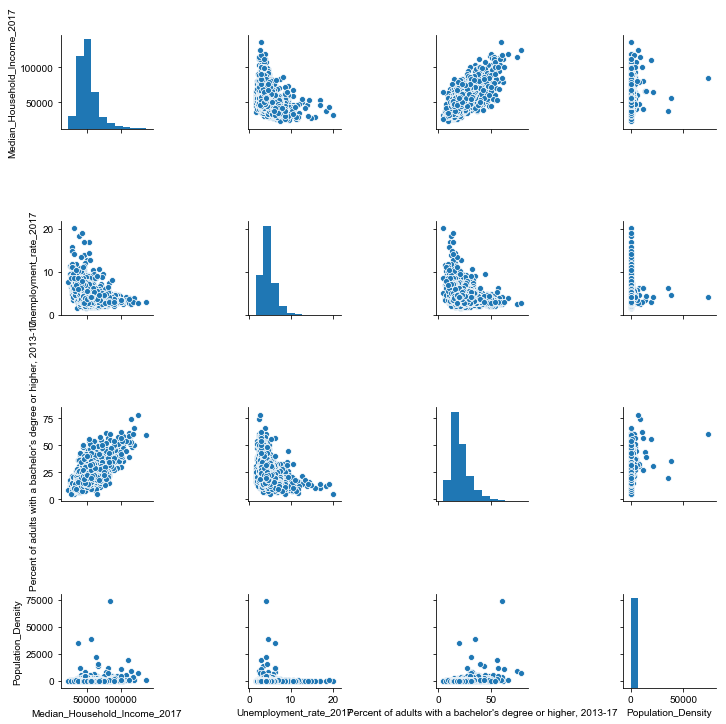

In [6]:
sns.pairplot(XY)

### 使用 `sklearn.linear_model`

分割資料、以訓練資料估計參數：

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = XY[['Unemployment_rate_2017', "Percent of adults with a bachelor's degree or higher, 2013-17",
        "Population_Density"]]
y = XY['Median_Household_Income_2017']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 9487)

regr = LinearRegression()
regr.fit(x_train, y_train)
print(regr.intercept_, regr.coef_)

36008.052051112274 [-1.23269227e+03  9.77652360e+02 -1.37986239e-02]


以估計之參數繪圖觀察成果，由於 X 為多維度資料，以 X、Y 作圖難以觀察成果，故以估計值 vs 實際值的散佈圖替代：

Text(0, 0.5, 'Real')

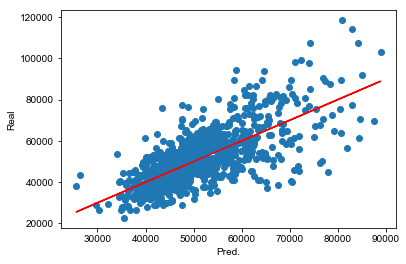

In [8]:
y_pred = regr.predict(x_test)
plt.scatter(y_pred, y_test)
plt.plot(y_pred, y_pred, 'r')
plt.xlabel("Pred.")
plt.ylabel("Real")

(紅色的線為 $Y_{實際} = Y_{預測}$，預測的越好所有的點要越靠近該直線)

### 使用 `statsmodels.api` 進行比較詳細的分析

使用 `sklearn.linear_model` 只能給出比較簡單的參數，若要比較「教科書式」的輸出，可藉由 `statsmodels.api` 分析

In [9]:
import statsmodels.api as sm

Xc = sm.add_constant(X) # 加常數項
model = sm.OLS(y, Xc).fit()
model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     Median_Household_Income_2017   R-squared:                       0.539
Model:                                      OLS   Adj. R-squared:                  0.538
Method:                           Least Squares   F-statistic:                     1221.
Date:                          Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                                  23:59:54   Log-Likelihood:                -33113.
No. Observations:                          3141   AIC:                         6.623e+04
Df Residuals:                              3137   BIC:                         6.626e+04
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
const                                                           3.73e+04    752.463     49.567      0.000    3.58e+04    3.88e+04
Unemployment_rate_2017                                        -1387.5982    104.587    -13.267      0.000   -1592.664   -1182.533
Percent of adults with a bachelor's degree or higher, 2013-17   952.3828     19.440     48.992      0.000     914.267     990.499
Population_Density                                                0.0121      0.092      0.131      0.895      -0.168       0.192
==============================================================================
Omnibus:                      255.025   Durbin-Watson:                   1.536
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              556.877
Skew:                           0.515   Prob(JB):                    1.19e-121
Kurtosis:                       4.787   Cond. No.                     8.60e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

可看出來人口密度是不顯著的，剛剛我們用測試資料的估計與實際值觀察，雖然所有資料都散佈在 $Y_{實際} = Y_{預測}$ 的直線附近，但實際上並非每個參數都該接受。